<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#하이퍼파라미터-세팅-및-seed-고정" data-toc-modified-id="하이퍼파라미터-세팅-및-seed-고정-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>하이퍼파라미터 세팅 및 seed 고정</a></span></li><li><span><a href="#학습-데이터-EDA" data-toc-modified-id="학습-데이터-EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>학습 데이터 EDA</a></span></li><li><span><a href="#데이터-전처리-함수-정의-(Dataset)" data-toc-modified-id="데이터-전처리-함수-정의-(Dataset)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>데이터 전처리 함수 정의 (Dataset)</a></span></li><li><span><a href="#Dataset-정의-및-DataLoader-할당" data-toc-modified-id="Dataset-정의-및-DataLoader-할당-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Dataset 정의 및 DataLoader 할당</a></span><ul class="toc-item"><li><span><a href="#데이터-샘플-시각화-(Show-example-image-and-mask)" data-toc-modified-id="데이터-샘플-시각화-(Show-example-image-and-mask)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>데이터 샘플 시각화 (Show example image and mask)</a></span></li></ul></li><li><span><a href="#baseline-model" data-toc-modified-id="baseline-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>baseline model</a></span><ul class="toc-item"><li><span><a href="#models.segmentation.fcn_resnet50" data-toc-modified-id="models.segmentation.fcn_resnet50-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>models.segmentation.fcn_resnet50</a></span></li></ul></li><li><span><a href="#train,-validation,-test-함수-정의" data-toc-modified-id="train,-validation,-test-함수-정의-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>train, validation, test 함수 정의</a></span></li><li><span><a href="#모델-저장-함수-정의" data-toc-modified-id="모델-저장-함수-정의-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>모델 저장 함수 정의</a></span></li><li><span><a href="#모델-생성-및-Loss-function,-Optimizer-정의" data-toc-modified-id="모델-생성-및-Loss-function,-Optimizer-정의-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>모델 생성 및 Loss function, Optimizer 정의</a></span></li><li><span><a href="#저장된-model-불러오기-(학습된-이후)" data-toc-modified-id="저장된-model-불러오기-(학습된-이후)-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>저장된 model 불러오기 (학습된 이후)</a></span><ul class="toc-item"><li><span><a href="#plot_examples()-시각화-함수-정의" data-toc-modified-id="plot_examples()-시각화-함수-정의-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span><code>plot_examples()</code> 시각화 함수 정의</a></span><ul class="toc-item"><li><span><a href="#train-set-시각화" data-toc-modified-id="train-set-시각화-9.1.1"><span class="toc-item-num">9.1.1&nbsp;&nbsp;</span>train set 시각화</a></span></li><li><span><a href="#validation-set-시각화" data-toc-modified-id="validation-set-시각화-9.1.2"><span class="toc-item-num">9.1.2&nbsp;&nbsp;</span>validation set 시각화</a></span></li><li><span><a href="#test-set-시각화" data-toc-modified-id="test-set-시각화-9.1.3"><span class="toc-item-num">9.1.3&nbsp;&nbsp;</span>test set 시각화</a></span></li></ul></li></ul></li><li><span><a href="#submission을-위한-test-함수-정의" data-toc-modified-id="submission을-위한-test-함수-정의-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>submission을 위한 test 함수 정의</a></span></li><li><span><a href="#submission.csv-생성" data-toc-modified-id="submission.csv-생성-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>submission.csv 생성</a></span></li></ul></div>

In [11]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from utils import label_accuracy_score, add_hist
import cv2

import numpy as np
import pandas as pd
from tqdm import tqdm

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.patches import Patch
import webcolors

plt.rcParams['axes.grid'] = False

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

# GPU 사용 가능 여부에 따라 device 정보 저장
device = "cuda" if torch.cuda.is_available() else "cpu"

pytorch version: 1.7.1
GPU 사용 가능 여부: True
Tesla V100-SXM2-32GB
1


## 하이퍼파라미터 세팅 및 seed 고정

In [12]:
batch_size = 16   # Mini-batch size
num_epochs = 20
learning_rate = 0.0001

In [13]:
# seed 고정
random_seed = 21
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

## 학습 데이터 EDA

In [14]:
%matplotlib inline

dataset_path  = '/opt/ml/segmentation/input/data'
anns_file_path = dataset_path + '/' + 'base_json/train_all.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 10
Number of categories: 10
Number of annotations: 26240
Number of images: 3272


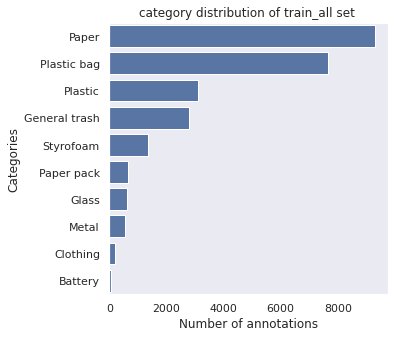

In [15]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']-1] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
plt.title("category distribution of train_all set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")

In [16]:
# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

In [17]:
# class (Categories) 에 따른 index 확인 (0~10 : 총 11개)
sorted_df

,Categories,Number of annotations
0,Backgroud,NaN
1,General trash,2782.0
2,Paper,9311.0
3,Paper pack,659.0
4,Metal,562.0
5,Glass,610.0
6,Plastic,3090.0
7,Styrofoam,1343.0
8,Plastic bag,7643.0
9,Battery,63.0


In [18]:
sorted_df['Categories']

0         Backgroud
1     General trash
2             Paper
3        Paper pack
4             Metal
5             Glass
6           Plastic
7         Styrofoam
8       Plastic bag
9           Battery
10         Clothing
Name: Categories, dtype: object

## 데이터 전처리 함수 정의 (Dataset)

In [19]:
category_names = list(sorted_df.Categories)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        # getImgIds : list 형태 (이미지 id 내림차순으로 가져옴)
        image_id = self.coco.getImgIds(imgIds=index) 
        # loadImgs : list 형태 (한 번에 여러 이미지 정보 불러올 수 있는 형태) - 원소는 dict 형태
        image_infos = self.coco.loadImgs(image_id)[0] 
        
        """
        <image_infos 예시> - json 파일의 'images' 부분 정보
        {'license': 0,
        'url': None,
        'file_name': 'batch_01_vt/0024.jpg',
        'height': 512,
        'width': 512,
        'date_captured': None,
        'id': 14}
        """
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            # ann_ids : 해당 이미지에 포함 된 모든 annotation들의 id 가져옴
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            # anns : 해당 annotation들의 정보 가져옴 (json 파일의 'annotation' 부분 정보)
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            # getCatIds : 카테고리 id 전부 불러오기 - [1,2,3,...,9,10]
            cat_ids = self.coco.getCatIds()
            # loadCats(cat_ids) : cat_ids의 category 정보 가져오기 (json 파일의 'categories' 부분 정보)
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # General trash = 1, ... , Cigarette = 10
            anns = sorted(anns, key=lambda idx : len(idx['segmentation'][0]), reverse=False)
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks[self.coco.annToMask(anns[i]) == 1] = pixel_value
            masks = masks.astype(np.int8)
                        
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            return images, masks, image_infos
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            return images, image_infos
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

In [20]:
category_names

['Backgroud',
 'General trash',
 'Paper',
 'Paper pack',
 'Metal',
 'Glass',
 'Plastic',
 'Styrofoam',
 'Plastic bag',
 'Battery',
 'Clothing']

In [21]:
coco = COCO(dataset_path + '/base_json/train.json')

loading annotations into memory...
Done (t=3.95s)
creating index...
index created!


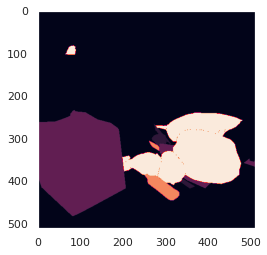

In [22]:
image_id = coco.getImgIds(imgIds=14) 
image_infos = coco.loadImgs(image_id)[0] 

# cv2 를 활용하여 image 불러오기
images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
images /= 255.0 # images - type(numpy.ndarray)

# train, val 모드
ann_ids = coco.getAnnIds(imgIds=image_infos['id'])
anns = coco.loadAnns(ann_ids)

# Load the categories in a variable
cat_ids = coco.getCatIds()
cats = coco.loadCats(cat_ids)

# masks : size가 (height x width)인 2D
# 각각의 pixel 값에는 "category id" 할당
# Background = 0
masks = np.zeros((image_infos["height"], image_infos["width"]))
# General trash = 1, ... , Cigarette = 10
# 해당 부분에 문제 있다는 의견 (slack 확인)
# 영역 큰 객체부터 먼저 색을 입히고, 이후 겹쳐지는 작은 이미지를 더 위에 입힐 수 있도록 함
anns = sorted(anns, key=lambda idx : idx['area'], reverse=True)
for i in range(len(anns)):
    className = get_classname(anns[i]['category_id'], cats)
    pixel_value = category_names.index(className) # className의 index 돌려줌 (class_id)
    masks[coco.annToMask(anns[i]) == 1] = pixel_value # mask 해당하는 픽셀을 class_id로 변경
masks = masks.astype(np.int8)
plt.imshow(masks)
plt.show()
                
#     # transform -> albumentations 라이브러리 활용
#     if self.transform is not None:
#         transformed = self.transform(image=images, mask=masks)
#         images = transformed["image"]
#         masks = transformed["mask"]
#     return images, masks, image_infos

# if self.mode == 'test':
#     # transform -> albumentations 라이브러리 활용
#     if self.transform is not None:
#         transformed = self.transform(image=images)
#         images = transformed["image"]
#     return images, image_infos

In [23]:
coco.annToMask(anns[0]) == 1

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

## Dataset 정의 및 DataLoader 할당

In [26]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = dataset_path + '/base_json/train.json'
val_path = dataset_path + '/base_json/val.json'
test_path = dataset_path + '/test.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))


import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
                            ToTensorV2()
                            ])

val_transform = A.Compose([
                          ToTensorV2()
                          ])

test_transform = A.Compose([
                           ToTensorV2()
                           ])

# create own Dataset 1 (skip)
# validation set을 직접 나누고 싶은 경우
# random_split 사용하여 data set을 8:2 로 분할
# train_size = int(0.8*len(dataset))
# val_size = int(len(dataset)-train_size)
# dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=transform)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# create own Dataset 2
# train dataset
train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)

# validation dataset
val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=val_transform)

# test dataset
test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)


# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=4,
                                           collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=4,
                                         collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          num_workers=4,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=4.39s)
creating index...
index created!
loading annotations into memory...
Done (t=0.85s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


### 데이터 샘플 시각화 (Show example image and mask)

- `train_loader` 
- `val_loader` 
- `test_loader` 

In [27]:
class_colormap = pd.read_csv("class_dict.csv")
class_colormap

,name,r,g,b
0,Backgroud,0,0,0
1,General trash,192,0,128
2,Paper,0,128,192
3,Paper pack,0,128,64
4,Metal,128,0,0
5,Glass,64,0,128
6,Plastic,64,0,192
7,Styrofoam,192,128,64
8,Plastic bag,192,192,128
9,Battery,64,64,128


In [28]:
def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

image shape: [3, 512, 512]
mask shape:  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {2, 'Paper'}, {8, 'Plastic bag'}]


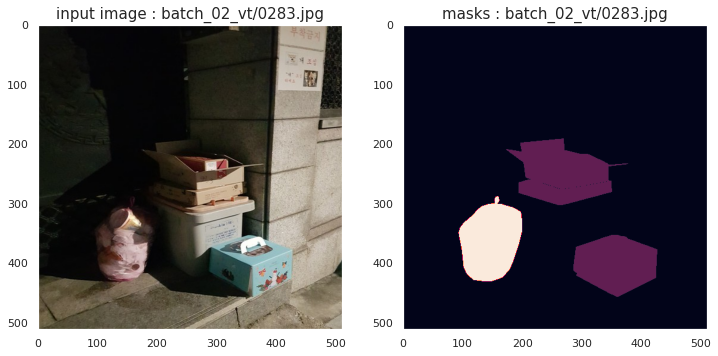

In [29]:
# train_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in train_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))
print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

image shape: [3, 512, 512]
mask shape:  [512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {'Glass', 5}, {'Plastic', 6}, {8, 'Plastic bag'}]


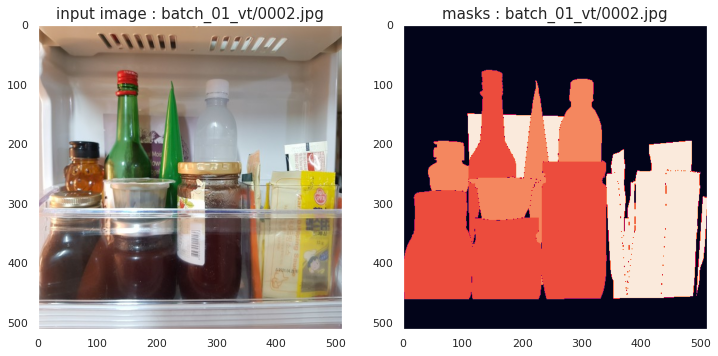

In [30]:
# val_loader의 output 결과(image 및 mask) 확인
for imgs, masks, image_infos in val_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    temp_masks = masks
    
    break

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(temp_images[0].shape))
print('mask shape: ', list(temp_masks[0].shape))

print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks[0]))])

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

ax2.imshow(temp_masks[0])
ax2.grid(False)
ax2.set_title("masks : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

image shape: [3, 512, 512]


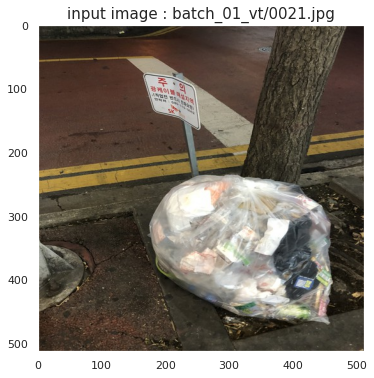

In [ ]:
# test_loader의 output 결과(image) 확인
for imgs, image_infos in test_loader:
    image_infos = image_infos[0]
    temp_images = imgs
    
    break

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

print('image shape:', list(temp_images[0].shape))

ax1.imshow(temp_images[0].permute([1,2,0]))
ax1.grid(False)
ax1.set_title("input image : {}".format(image_infos['file_name']), fontsize = 15)

plt.show()

## baseline model

### models.segmentation.fcn_resnet50

In [31]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

model = models.segmentation.fcn_resnet50(pretrained=True)

# output class를 data set에 맞도록 수정
model.classifier[4] = nn.Conv2d(512, 11, kernel_size=1)

In [ ]:
# 구현된 model에 임의의 input을 넣어 output이 잘 나오는지 test
x = torch.randn([2, 3, 512, 512])
print(f"input shape : {x.shape}")
out = model(x)['out']
print(f"output shape : {out.size()}")

input shape : torch.Size([2, 3, 512, 512])
output shape : torch.Size([2, 11, 512, 512])


## train, validation, test 함수 정의

In [ ]:
def train(num_epochs, model, data_loader, val_loader, criterion, optimizer, saved_dir, val_every, device):
    print(f'Start training..')
    n_class = 11
    best_loss = 9999999
    
    for epoch in range(num_epochs):
        model.train()

        hist = np.zeros((n_class, n_class))
        for step, (images, masks, _) in enumerate(data_loader):
            images = torch.stack(images)       
            masks = torch.stack(masks).long() 
            
            # gpu 연산을 위해 device 할당
            images, masks = images.to(device), masks.to(device)
            
            # device 할당
            model = model.to(device)
            
            # inference
            outputs = model(images)['out']
            
            # loss 계산 (cross entropy loss)
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            outputs = torch.argmax(outputs, dim=1).detach().cpu().numpy()
            masks = masks.detach().cpu().numpy()
            
            hist = add_hist(hist, masks, outputs, n_class=n_class)
            acc, acc_cls, mIoU, fwavacc, IoU = label_accuracy_score(hist)
            
            # step 주기에 따른 loss 출력
            if (step + 1) % 25 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{step+1}/{len(train_loader)}], \
                        Loss: {round(loss.item(),4)}, mIoU: {round(mIoU,4)}')
             
        # validation 주기에 따른 loss 출력 및 best model 저장
        if (epoch + 1) % val_every == 0:
            avrg_loss = validation(epoch + 1, model, val_loader, criterion, device)
            if avrg_loss < best_loss:
                print(f"Best performance at epoch: {epoch + 1}")
                print(f"Save model in {saved_dir}")
                best_loss = avrg_loss
                save_model(model, saved_dir)

In [ ]:
def validation(epoch, model, data_loader, criterion, device):
    print(f'Start validation #{epoch}')
    model.eval()

    with torch.no_grad():
        n_class = 11
        total_loss = 0
        cnt = 0
        
        hist = np.zeros((n_class, n_class))
        for step, (images, masks, _) in enumerate(data_loader):
            
            images = torch.stack(images)       
            masks = torch.stack(masks).long()  

            images, masks = images.to(device), masks.to(device)            
            
            # device 할당
            model = model.to(device)
            
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            total_loss += loss
            cnt += 1
            
            outputs = torch.argmax(outputs, dim=1).detach().cpu().numpy()
            masks = masks.detach().cpu().numpy()
            
            hist = add_hist(hist, masks, outputs, n_class=n_class)
        
        acc, acc_cls, mIoU, fwavacc, IoU = label_accuracy_score(hist)
        IoU_by_class = [{classes : round(IoU,4)} for IoU, classes in zip(IoU , sorted_df['Categories'])]
        
        avrg_loss = total_loss / cnt
        print(f'Validation #{epoch}  Average Loss: {round(avrg_loss.item(), 4)}, Accuracy : {round(acc, 4)}, \
                mIoU: {round(mIoU, 4)}')
        print(f'IoU by class : {IoU_by_class}')
        
    return avrg_loss

## 모델 저장 함수 정의

In [ ]:
# 모델 저장 함수 정의
val_every = 1

saved_dir = './saved'
if not os.path.isdir(saved_dir):                                                           
    os.mkdir(saved_dir)

def save_model(model, saved_dir, file_name='fcn_resnet50_best_model(pretrained).pt'):
    check_point = {'net': model.state_dict()}
    output_path = os.path.join(saved_dir, file_name)
    torch.save(model, output_path)

## 모델 생성 및 Loss function, Optimizer 정의

In [32]:
# Loss function 정의
criterion = nn.CrossEntropyLoss()

# Optimizer 정의
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate, weight_decay=1e-6)

In [ ]:
train(num_epochs, model, train_loader, val_loader, criterion, optimizer, saved_dir, val_every, device)

  0%|          | 0/20 [00:00<?, ?it/s]

Start training..
Epoch [1/20], Step [25/164],                         Loss: 0.8489, mIoU: 0.201
Epoch [1/20], Step [50/164],                         Loss: 0.8199, mIoU: 0.2283
Epoch [1/20], Step [75/164],                         Loss: 0.5771, mIoU: 0.2386
Epoch [1/20], Step [100/164],                         Loss: 0.7356, mIoU: 0.2514
Epoch [1/20], Step [125/164],                         Loss: 0.5571, mIoU: 0.26
Epoch [1/20], Step [150/164],                         Loss: 0.3802, mIoU: 0.2686
Start validation #1
Validation #1  Average Loss: 0.4703, Accuracy : 0.881,                 mIoU: 0.323
IoU by class : [{'Backgroud': 0.933}, {'General trash': 0.1915}, {'Paper': 0.6276}, {'Paper pack': 0.0001}, {'Metal': 0.0271}, {'Glass': 0.3194}, {'Plastic': 0.2493}, {'Styrofoam': 0.4594}, {'Plastic bag': 0.7458}, {'Battery': 0.0}, {'Clothing': 0.0}]
Best performance at epoch: 1
Save model in ./saved


  5%|▌         | 1/20 [04:46<1:30:38, 286.25s/it]

Epoch [2/20], Step [25/164],                         Loss: 0.3188, mIoU: 0.3339
Epoch [2/20], Step [50/164],                         Loss: 0.3073, mIoU: 0.3427
Epoch [2/20], Step [75/164],                         Loss: 0.3577, mIoU: 0.3482
Epoch [2/20], Step [100/164],                         Loss: 0.2948, mIoU: 0.3565
Epoch [2/20], Step [125/164],                         Loss: 0.3467, mIoU: 0.3622
Epoch [2/20], Step [150/164],                         Loss: 0.3103, mIoU: 0.3623
Start validation #2
Validation #2  Average Loss: 0.3543, Accuracy : 0.896,                 mIoU: 0.3637
IoU by class : [{'Backgroud': 0.9371}, {'General trash': 0.3059}, {'Paper': 0.6616}, {'Paper pack': 0.0608}, {'Metal': 0.2159}, {'Glass': 0.2237}, {'Plastic': 0.259}, {'Styrofoam': 0.5533}, {'Plastic bag': 0.783}, {'Battery': 0.0}, {'Clothing': 0.0}]
Best performance at epoch: 2
Save model in ./saved


 10%|█         | 2/20 [09:33<1:25:55, 286.42s/it]

Epoch [3/20], Step [25/164],                         Loss: 0.2535, mIoU: 0.4564
Epoch [3/20], Step [50/164],                         Loss: 0.1952, mIoU: 0.4702
Epoch [3/20], Step [75/164],                         Loss: 0.2138, mIoU: 0.4781
Epoch [3/20], Step [100/164],                         Loss: 0.2549, mIoU: 0.4634
Epoch [3/20], Step [125/164],                         Loss: 0.195, mIoU: 0.4606
Epoch [3/20], Step [150/164],                         Loss: 0.2618, mIoU: 0.4605
Start validation #3
Validation #3  Average Loss: 0.3361, Accuracy : 0.902,                 mIoU: 0.419
IoU by class : [{'Backgroud': 0.9399}, {'General trash': 0.2992}, {'Paper': 0.6469}, {'Paper pack': 0.1609}, {'Metal': 0.2851}, {'Glass': 0.3861}, {'Plastic': 0.3263}, {'Styrofoam': 0.5421}, {'Plastic bag': 0.7881}, {'Battery': 0.0}, {'Clothing': 0.2346}]
Best performance at epoch: 3
Save model in ./saved


 15%|█▌        | 3/20 [14:17<1:21:01, 285.96s/it]

Epoch [4/20], Step [25/164],                         Loss: 0.1864, mIoU: 0.5293
Epoch [4/20], Step [50/164],                         Loss: 0.1748, mIoU: 0.539
Epoch [4/20], Step [75/164],                         Loss: 0.141, mIoU: 0.5494
Epoch [4/20], Step [100/164],                         Loss: 0.2999, mIoU: 0.5462
Epoch [4/20], Step [125/164],                         Loss: 0.2349, mIoU: 0.55
Epoch [4/20], Step [150/164],                         Loss: 0.1297, mIoU: 0.5515
Start validation #4


 20%|██        | 4/20 [19:02<1:16:07, 285.46s/it]

Validation #4  Average Loss: 0.3487, Accuracy : 0.8974,                 mIoU: 0.3914
IoU by class : [{'Backgroud': 0.9421}, {'General trash': 0.2998}, {'Paper': 0.6697}, {'Paper pack': 0.2004}, {'Metal': 0.0719}, {'Glass': 0.1999}, {'Plastic': 0.3048}, {'Styrofoam': 0.571}, {'Plastic bag': 0.7785}, {'Battery': 0.0}, {'Clothing': 0.2672}]
Epoch [5/20], Step [25/164],                         Loss: 0.2093, mIoU: 0.5754
Epoch [5/20], Step [50/164],                         Loss: 0.2145, mIoU: 0.6084
Epoch [5/20], Step [75/164],                         Loss: 0.2962, mIoU: 0.6091
Epoch [5/20], Step [100/164],                         Loss: 0.1616, mIoU: 0.6076
Epoch [5/20], Step [125/164],                         Loss: 0.1743, mIoU: 0.6018
Epoch [5/20], Step [150/164],                         Loss: 0.1353, mIoU: 0.6047
Start validation #5


 25%|██▌       | 5/20 [23:45<1:11:12, 284.86s/it]

Validation #5  Average Loss: 0.3559, Accuracy : 0.8996,                 mIoU: 0.4357
IoU by class : [{'Backgroud': 0.9412}, {'General trash': 0.2562}, {'Paper': 0.6485}, {'Paper pack': 0.2508}, {'Metal': 0.3218}, {'Glass': 0.3919}, {'Plastic': 0.3535}, {'Styrofoam': 0.5311}, {'Plastic bag': 0.7556}, {'Battery': 0.0}, {'Clothing': 0.3428}]
Epoch [6/20], Step [25/164],                         Loss: 0.1347, mIoU: 0.6818
Epoch [6/20], Step [50/164],                         Loss: 0.1635, mIoU: 0.6841
Epoch [6/20], Step [75/164],                         Loss: 0.1248, mIoU: 0.6811
Epoch [6/20], Step [100/164],                         Loss: 0.2053, mIoU: 0.6708
Epoch [6/20], Step [125/164],                         Loss: 0.1267, mIoU: 0.673
Epoch [6/20], Step [150/164],                         Loss: 0.1227, mIoU: 0.6719
Start validation #6


 30%|███       | 6/20 [28:28<1:06:18, 284.16s/it]

Validation #6  Average Loss: 0.3372, Accuracy : 0.9042,                 mIoU: 0.4423
IoU by class : [{'Backgroud': 0.9432}, {'General trash': 0.3205}, {'Paper': 0.6841}, {'Paper pack': 0.2857}, {'Metal': 0.2886}, {'Glass': 0.3927}, {'Plastic': 0.3313}, {'Styrofoam': 0.553}, {'Plastic bag': 0.7926}, {'Battery': 0.0}, {'Clothing': 0.2734}]
Epoch [7/20], Step [25/164],                         Loss: 0.1102, mIoU: 0.7248
Epoch [7/20], Step [50/164],                         Loss: 0.0669, mIoU: 0.7358
Epoch [7/20], Step [75/164],                         Loss: 0.1484, mIoU: 0.7342
Epoch [7/20], Step [100/164],                         Loss: 0.1781, mIoU: 0.7308
Epoch [7/20], Step [125/164],                         Loss: 0.1097, mIoU: 0.7283
Epoch [7/20], Step [150/164],                         Loss: 0.1167, mIoU: 0.7236
Start validation #7


 35%|███▌      | 7/20 [33:11<1:01:29, 283.82s/it]

Validation #7  Average Loss: 0.3612, Accuracy : 0.9058,                 mIoU: 0.4266
IoU by class : [{'Backgroud': 0.941}, {'General trash': 0.2608}, {'Paper': 0.656}, {'Paper pack': 0.2162}, {'Metal': 0.2714}, {'Glass': 0.4256}, {'Plastic': 0.3198}, {'Styrofoam': 0.5418}, {'Plastic bag': 0.7989}, {'Battery': 0.0}, {'Clothing': 0.2611}]
Epoch [8/20], Step [25/164],                         Loss: 0.1586, mIoU: 0.732
Epoch [8/20], Step [50/164],                         Loss: 0.0851, mIoU: 0.7455
Epoch [8/20], Step [75/164],                         Loss: 0.0718, mIoU: 0.7481
Epoch [8/20], Step [100/164],                         Loss: 0.0608, mIoU: 0.7522
Epoch [8/20], Step [125/164],                         Loss: 0.1007, mIoU: 0.7645
Epoch [8/20], Step [150/164],                         Loss: 0.0914, mIoU: 0.7676
Start validation #8


 40%|████      | 8/20 [37:54<56:44, 283.67s/it]  

Validation #8  Average Loss: 0.3548, Accuracy : 0.9054,                 mIoU: 0.4483
IoU by class : [{'Backgroud': 0.9436}, {'General trash': 0.3105}, {'Paper': 0.6785}, {'Paper pack': 0.2236}, {'Metal': 0.316}, {'Glass': 0.4508}, {'Plastic': 0.3297}, {'Styrofoam': 0.6199}, {'Plastic bag': 0.7824}, {'Battery': 0.0444}, {'Clothing': 0.2317}]
Epoch [9/20], Step [25/164],                         Loss: 0.0764, mIoU: 0.8785
Epoch [9/20], Step [50/164],                         Loss: 0.1449, mIoU: 0.7886
Epoch [9/20], Step [75/164],                         Loss: 0.0636, mIoU: 0.8044
Epoch [9/20], Step [100/164],                         Loss: 0.1191, mIoU: 0.822
Epoch [9/20], Step [125/164],                         Loss: 0.0966, mIoU: 0.8242
Epoch [9/20], Step [150/164],                         Loss: 0.0929, mIoU: 0.8238
Start validation #9


 45%|████▌     | 9/20 [42:37<51:59, 283.56s/it]

Validation #9  Average Loss: 0.3636, Accuracy : 0.8974,                 mIoU: 0.4754
IoU by class : [{'Backgroud': 0.9395}, {'General trash': 0.2803}, {'Paper': 0.6974}, {'Paper pack': 0.3449}, {'Metal': 0.2612}, {'Glass': 0.387}, {'Plastic': 0.3508}, {'Styrofoam': 0.6317}, {'Plastic bag': 0.7633}, {'Battery': 0.3257}, {'Clothing': 0.2477}]
Epoch [10/20], Step [25/164],                         Loss: 0.0887, mIoU: 0.7864
Epoch [10/20], Step [50/164],                         Loss: 0.0782, mIoU: 0.7899
Epoch [10/20], Step [75/164],                         Loss: 0.0615, mIoU: 0.808
Epoch [10/20], Step [100/164],                         Loss: 0.0944, mIoU: 0.8429
Epoch [10/20], Step [125/164],                         Loss: 0.0698, mIoU: 0.8517
Epoch [10/20], Step [150/164],                         Loss: 0.154, mIoU: 0.8453
Start validation #10


 50%|█████     | 10/20 [47:20<47:13, 283.38s/it]

Validation #10  Average Loss: 0.3653, Accuracy : 0.9075,                 mIoU: 0.4829
IoU by class : [{'Backgroud': 0.9406}, {'General trash': 0.3073}, {'Paper': 0.6789}, {'Paper pack': 0.318}, {'Metal': 0.3482}, {'Glass': 0.373}, {'Plastic': 0.3447}, {'Styrofoam': 0.5923}, {'Plastic bag': 0.7891}, {'Battery': 0.3595}, {'Clothing': 0.2607}]
Epoch [11/20], Step [25/164],                         Loss: 0.0628, mIoU: 0.8252
Epoch [11/20], Step [50/164],                         Loss: 0.0719, mIoU: 0.8731
Epoch [11/20], Step [75/164],                         Loss: 0.0485, mIoU: 0.8704
Epoch [11/20], Step [100/164],                         Loss: 0.063, mIoU: 0.8729
Epoch [11/20], Step [125/164],                         Loss: 0.0522, mIoU: 0.8627
Epoch [11/20], Step [150/164],                         Loss: 0.0785, mIoU: 0.8604
Start validation #11


 55%|█████▌    | 11/20 [52:04<42:31, 283.49s/it]

Validation #11  Average Loss: 0.3881, Accuracy : 0.9063,                 mIoU: 0.4473
IoU by class : [{'Backgroud': 0.9472}, {'General trash': 0.3273}, {'Paper': 0.6663}, {'Paper pack': 0.3017}, {'Metal': 0.248}, {'Glass': 0.3249}, {'Plastic': 0.329}, {'Styrofoam': 0.6058}, {'Plastic bag': 0.7909}, {'Battery': 0.1313}, {'Clothing': 0.2479}]
Epoch [12/20], Step [25/164],                         Loss: 0.0484, mIoU: 0.8797
Epoch [12/20], Step [50/164],                         Loss: 0.0733, mIoU: 0.8914
Epoch [12/20], Step [75/164],                         Loss: 0.0512, mIoU: 0.8947
Epoch [12/20], Step [100/164],                         Loss: 0.0742, mIoU: 0.8958
Epoch [12/20], Step [125/164],                         Loss: 0.0616, mIoU: 0.8961
Epoch [12/20], Step [150/164],                         Loss: 0.0806, mIoU: 0.8928
Start validation #12


 60%|██████    | 12/20 [56:47<37:46, 283.30s/it]

Validation #12  Average Loss: 0.3442, Accuracy : 0.9132,                 mIoU: 0.4823
IoU by class : [{'Backgroud': 0.9482}, {'General trash': 0.3278}, {'Paper': 0.6863}, {'Paper pack': 0.1696}, {'Metal': 0.3411}, {'Glass': 0.4594}, {'Plastic': 0.3546}, {'Styrofoam': 0.6137}, {'Plastic bag': 0.8115}, {'Battery': 0.312}, {'Clothing': 0.2813}]
Epoch [13/20], Step [25/164],                         Loss: 0.0565, mIoU: 0.8099
Epoch [13/20], Step [50/164],                         Loss: 0.0468, mIoU: 0.8036
Epoch [13/20], Step [75/164],                         Loss: 0.0412, mIoU: 0.8886
Epoch [13/20], Step [100/164],                         Loss: 0.063, mIoU: 0.8939
Epoch [13/20], Step [125/164],                         Loss: 0.0647, mIoU: 0.896
Epoch [13/20], Step [150/164],                         Loss: 0.0745, mIoU: 0.8998
Start validation #13


 65%|██████▌   | 13/20 [1:01:29<33:01, 283.02s/it]

Validation #13  Average Loss: 0.3534, Accuracy : 0.9155,                 mIoU: 0.5187
IoU by class : [{'Backgroud': 0.9489}, {'General trash': 0.35}, {'Paper': 0.7083}, {'Paper pack': 0.3561}, {'Metal': 0.3559}, {'Glass': 0.4578}, {'Plastic': 0.357}, {'Styrofoam': 0.6125}, {'Plastic bag': 0.8168}, {'Battery': 0.482}, {'Clothing': 0.2603}]
Epoch [14/20], Step [25/164],                         Loss: 0.0512, mIoU: 0.9225
Epoch [14/20], Step [50/164],                         Loss: 0.0413, mIoU: 0.928
Epoch [14/20], Step [75/164],                         Loss: 0.0395, mIoU: 0.9287
Epoch [14/20], Step [100/164],                         Loss: 0.037, mIoU: 0.9269
Epoch [14/20], Step [125/164],                         Loss: 0.0809, mIoU: 0.9261
Epoch [14/20], Step [150/164],                         Loss: 0.0699, mIoU: 0.9251
Start validation #14


 70%|███████   | 14/20 [1:06:14<28:20, 283.48s/it]

Validation #14  Average Loss: 0.3525, Accuracy : 0.9153,                 mIoU: 0.4941
IoU by class : [{'Backgroud': 0.9471}, {'General trash': 0.3531}, {'Paper': 0.7126}, {'Paper pack': 0.3284}, {'Metal': 0.3486}, {'Glass': 0.4206}, {'Plastic': 0.3595}, {'Styrofoam': 0.6118}, {'Plastic bag': 0.812}, {'Battery': 0.2107}, {'Clothing': 0.3305}]
Epoch [15/20], Step [25/164],                         Loss: 0.0441, mIoU: 0.9306
Epoch [15/20], Step [50/164],                         Loss: 0.0483, mIoU: 0.9271
Epoch [15/20], Step [75/164],                         Loss: 0.0398, mIoU: 0.929
Epoch [15/20], Step [100/164],                         Loss: 0.0365, mIoU: 0.9271
Epoch [15/20], Step [125/164],                         Loss: 0.0355, mIoU: 0.9288
Epoch [15/20], Step [150/164],                         Loss: 0.0367, mIoU: 0.9273
Start validation #15


 75%|███████▌  | 15/20 [1:10:56<23:35, 283.15s/it]

Validation #15  Average Loss: 0.363, Accuracy : 0.9167,                 mIoU: 0.5028
IoU by class : [{'Backgroud': 0.9484}, {'General trash': 0.3687}, {'Paper': 0.7073}, {'Paper pack': 0.3346}, {'Metal': 0.3414}, {'Glass': 0.4374}, {'Plastic': 0.3745}, {'Styrofoam': 0.6532}, {'Plastic bag': 0.8141}, {'Battery': 0.2621}, {'Clothing': 0.2891}]
Epoch [16/20], Step [25/164],                         Loss: 0.0445, mIoU: 0.9356
Epoch [16/20], Step [50/164],                         Loss: 0.0479, mIoU: 0.9374
Epoch [16/20], Step [75/164],                         Loss: 0.0311, mIoU: 0.9372
Epoch [16/20], Step [100/164],                         Loss: 0.031, mIoU: 0.936
Epoch [16/20], Step [125/164],                         Loss: 0.0357, mIoU: 0.9345
Epoch [16/20], Step [150/164],                         Loss: 0.033, mIoU: 0.9325
Start validation #16


 80%|████████  | 16/20 [1:15:36<18:49, 282.25s/it]

Validation #16  Average Loss: 0.3973, Accuracy : 0.913,                 mIoU: 0.4789
IoU by class : [{'Backgroud': 0.9444}, {'General trash': 0.3387}, {'Paper': 0.7014}, {'Paper pack': 0.297}, {'Metal': 0.3253}, {'Glass': 0.4137}, {'Plastic': 0.3304}, {'Styrofoam': 0.6174}, {'Plastic bag': 0.8104}, {'Battery': 0.2562}, {'Clothing': 0.233}]
Epoch [17/20], Step [25/164],                         Loss: 0.0335, mIoU: 0.9358
Epoch [17/20], Step [50/164],                         Loss: 0.0376, mIoU: 0.9322
Epoch [17/20], Step [75/164],                         Loss: 0.0509, mIoU: 0.9294
Epoch [17/20], Step [100/164],                         Loss: 0.0284, mIoU: 0.93
Epoch [17/20], Step [125/164],                         Loss: 0.027, mIoU: 0.929
Epoch [17/20], Step [150/164],                         Loss: 0.0363, mIoU: 0.9291
Start validation #17


 85%|████████▌ | 17/20 [1:20:19<14:07, 282.41s/it]

Validation #17  Average Loss: 0.4052, Accuracy : 0.9144,                 mIoU: 0.4951
IoU by class : [{'Backgroud': 0.9465}, {'General trash': 0.3509}, {'Paper': 0.6995}, {'Paper pack': 0.3205}, {'Metal': 0.3085}, {'Glass': 0.4572}, {'Plastic': 0.3373}, {'Styrofoam': 0.6219}, {'Plastic bag': 0.8121}, {'Battery': 0.3059}, {'Clothing': 0.2861}]
Epoch [18/20], Step [25/164],                         Loss: 0.0461, mIoU: 0.929
Epoch [18/20], Step [50/164],                         Loss: 0.0421, mIoU: 0.9255
Epoch [18/20], Step [75/164],                         Loss: 0.0518, mIoU: 0.9229
Epoch [18/20], Step [100/164],                         Loss: 0.1475, mIoU: 0.9068
Epoch [18/20], Step [125/164],                         Loss: 0.2171, mIoU: 0.8792
Epoch [18/20], Step [150/164],                         Loss: 0.124, mIoU: 0.8448
Start validation #18


 90%|█████████ | 18/20 [1:25:02<09:25, 282.63s/it]

Validation #18  Average Loss: 0.4411, Accuracy : 0.8724,                 mIoU: 0.3873
IoU by class : [{'Backgroud': 0.9153}, {'General trash': 0.263}, {'Paper': 0.595}, {'Paper pack': 0.2698}, {'Metal': 0.2473}, {'Glass': 0.3215}, {'Plastic': 0.2095}, {'Styrofoam': 0.3606}, {'Plastic bag': 0.748}, {'Battery': 0.1944}, {'Clothing': 0.1358}]
Epoch [19/20], Step [25/164],                         Loss: 0.1911, mIoU: 0.7664
Epoch [19/20], Step [50/164],                         Loss: 0.0682, mIoU: 0.7989
Epoch [19/20], Step [75/164],                         Loss: 0.1547, mIoU: 0.7994
Epoch [19/20], Step [100/164],                         Loss: 0.0771, mIoU: 0.794
Epoch [19/20], Step [125/164],                         Loss: 0.0712, mIoU: 0.8026
Epoch [19/20], Step [150/164],                         Loss: 0.1493, mIoU: 0.8005
Start validation #19


 95%|█████████▌| 19/20 [1:29:46<04:42, 282.92s/it]

Validation #19  Average Loss: 0.3597, Accuracy : 0.9083,                 mIoU: 0.4535
IoU by class : [{'Backgroud': 0.9442}, {'General trash': 0.3571}, {'Paper': 0.6827}, {'Paper pack': 0.2938}, {'Metal': 0.2802}, {'Glass': 0.4316}, {'Plastic': 0.313}, {'Styrofoam': 0.6249}, {'Plastic bag': 0.7986}, {'Battery': 0.0}, {'Clothing': 0.2619}]
Epoch [20/20], Step [25/164],                         Loss: 0.0959, mIoU: 0.8043
Epoch [20/20], Step [50/164],                         Loss: 0.0745, mIoU: 0.8436
Epoch [20/20], Step [75/164],                         Loss: 0.1348, mIoU: 0.8672
Epoch [20/20], Step [100/164],                         Loss: 0.0439, mIoU: 0.8713
Epoch [20/20], Step [125/164],                         Loss: 0.0571, mIoU: 0.8783
Epoch [20/20], Step [150/164],                         Loss: 0.054, mIoU: 0.8734
Start validation #20


100%|██████████| 20/20 [1:34:28<00:00, 282.67s/it]

Validation #20  Average Loss: 0.4007, Accuracy : 0.908,                 mIoU: 0.4756
IoU by class : [{'Backgroud': 0.9412}, {'General trash': 0.3232}, {'Paper': 0.6836}, {'Paper pack': 0.327}, {'Metal': 0.1881}, {'Glass': 0.4022}, {'Plastic': 0.3798}, {'Styrofoam': 0.63}, {'Plastic bag': 0.788}, {'Battery': 0.2837}, {'Clothing': 0.2851}]


## 저장된 model 불러오기 (학습된 이후) 

In [33]:
# best model 저장된 경로
model_path = './saved/fcn_resnet50_best_model(pretrained).pt'

# best model 불러오기
checkpoint = torch.load(model_path, map_location=device)
state_dict = checkpoint.state_dict()
model.load_state_dict(state_dict)

model = model.to(device)
# 추론을 실행하기 전에는 반드시 설정 (batch normalization, dropout 를 평가 모드로 설정)
# model.eval()

### `plot_examples()` 시각화 함수 정의

In [34]:
def plot_examples(mode="train", batch_id=0, num_examples=batch_size, dataloaer=train_loader):
    """Visualization of images and masks according to batch size
    Args:
        mode: train/val/test (str)
        batch_id : 0 (int) 
        num_examples : 1 ~ batch_size(e.g. 8) (int)
        dataloaer : data_loader (dataloader) 
    Returns:
        None
    """
    # variable for legend
    category_and_rgb = [[category, (r,g,b)] for idx, (category, r, g, b) in enumerate(class_colormap.values)]
    legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                             edgecolor=webcolors.rgb_to_hex(rgb), 
                             label=category) for category, rgb in category_and_rgb]
    
    # test / validation set에 대한 시각화
    if (mode in ('train', 'val')):
        with torch.no_grad():
            for index, (imgs, masks, image_infos) in enumerate(dataloaer):
                if index == batch_id:
                    image_infos = image_infos
                    temp_images = imgs
                    temp_masks = masks

                    model.eval()
                    # inference
                    outs = model(torch.stack(temp_images).to(device))['out']
                    oms = torch.argmax(outs, dim=1).detach().cpu().numpy()

                    break
                else:
                    continue
    
        fig, ax = plt.subplots(nrows=num_examples, ncols=3, figsize=(12, 4*num_examples), constrained_layout=True)
        fig.tight_layout()
        for row_num in range(num_examples):
            # Original Image
            ax[row_num][0].imshow(temp_images[row_num].permute([1,2,0]))
            ax[row_num][0].set_title(f"Orignal Image : {image_infos[row_num]['file_name']}")
            # Groud Truth
            ax[row_num][1].imshow(label_to_color_image(masks[row_num].detach().cpu().numpy()))
            ax[row_num][1].set_title(f"Groud Truth : {image_infos[row_num]['file_name']}")
            # Pred Mask
            ax[row_num][2].imshow(label_to_color_image(oms[row_num]))
            ax[row_num][2].set_title(f"Pred Mask : {image_infos[row_num]['file_name']}")
            ax[row_num][2].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
        plt.show()
    
    # test set에 대한 시각화
    else :
        with torch.no_grad():
            for index, (imgs, image_infos) in enumerate(dataloaer):
                if index == batch_id:
                    image_infos = image_infos
                    temp_images = imgs

                    model.eval()
                    
                    # inference
                    outs = model(torch.stack(temp_images).to(device))['out']
                    oms = torch.argmax(outs, dim=1).detach().cpu().numpy()
                    break
                else:
                    continue
    
        fig, ax = plt.subplots(nrows=num_examples, ncols=2, figsize=(10, 4*num_examples), constrained_layout=True)

        for row_num in range(num_examples):
            # Original Image
            ax[row_num][0].imshow(temp_images[row_num].permute([1,2,0]))
            ax[row_num][0].set_title(f"Orignal Image : {image_infos[row_num]['file_name']}")
            # Pred Mask
            ax[row_num][1].imshow(label_to_color_image(oms[row_num]))
            ax[row_num][1].set_title(f"Pred Mask : {image_infos[row_num]['file_name']}")
            ax[row_num][1].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
            
        plt.show()

In [38]:
with torch.no_grad():
    for index, (imgs, masks, image_infos) in enumerate(train_loader):
        if index == 0:
            image_infos = image_infos
            temp_images = imgs
            temp_masks = masks

            model.eval()
            # inference
            outs = model(torch.stack(temp_images).to(device))['out']
            oms = torch.argmax(outs, dim=1).detach().cpu().numpy()

            break
        else:
            continue

In [48]:
oms.shape
# plt.imshow(oms[0])
# plt.show()

(16, 512, 512)

#### train set 시각화

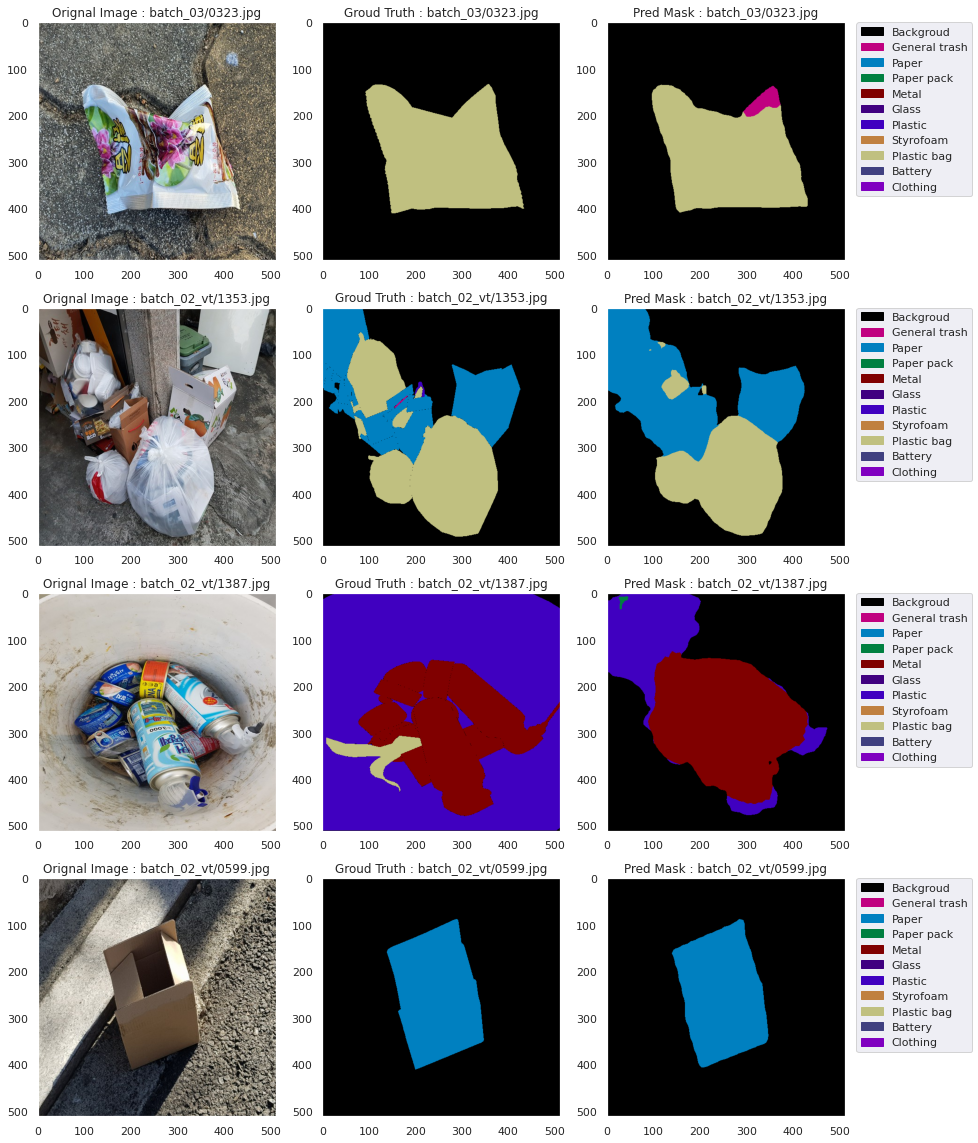

In [35]:
plot_examples(mode="train", batch_id=7, num_examples=4, dataloaer=train_loader)

#### validation set 시각화

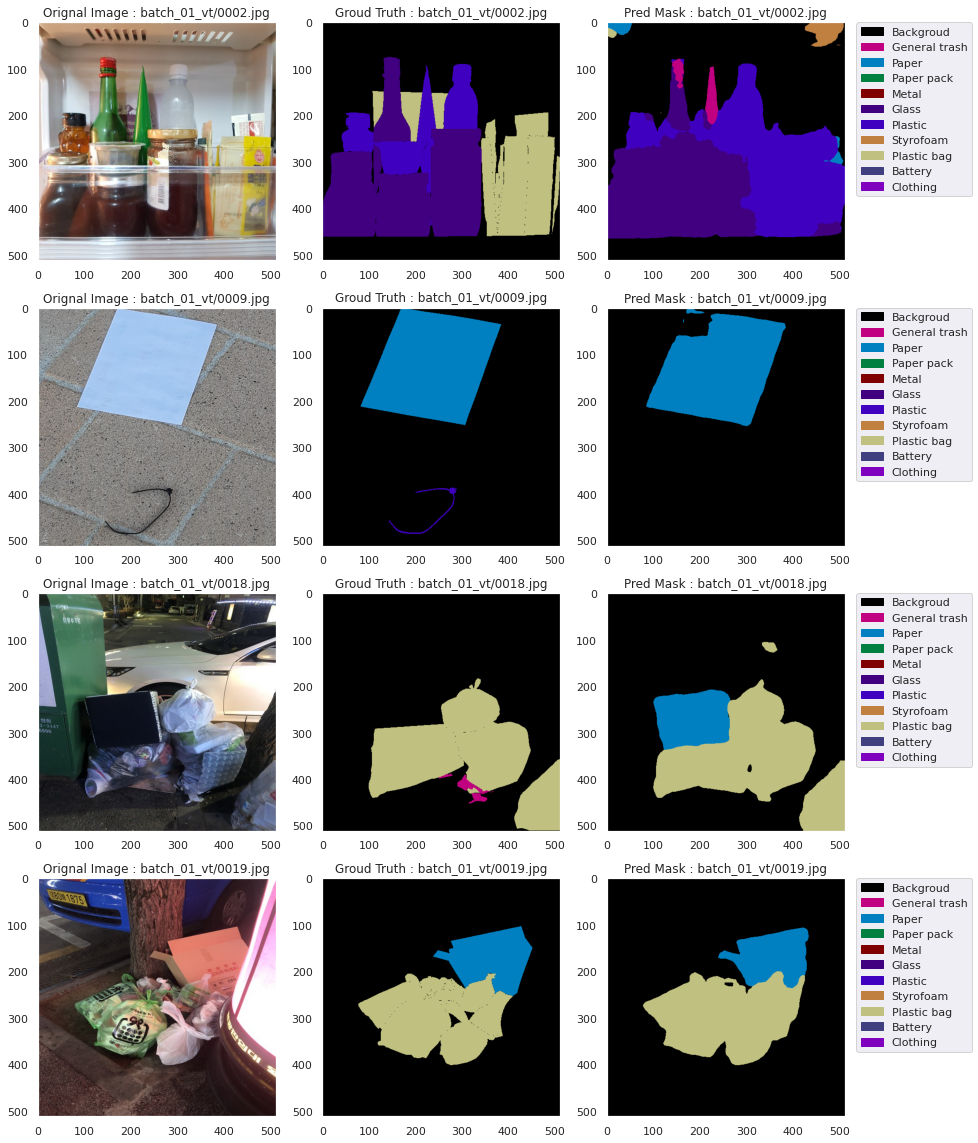

In [ ]:
plot_examples(mode="val", batch_id=0, num_examples=4, dataloaer=val_loader)

#### test set 시각화

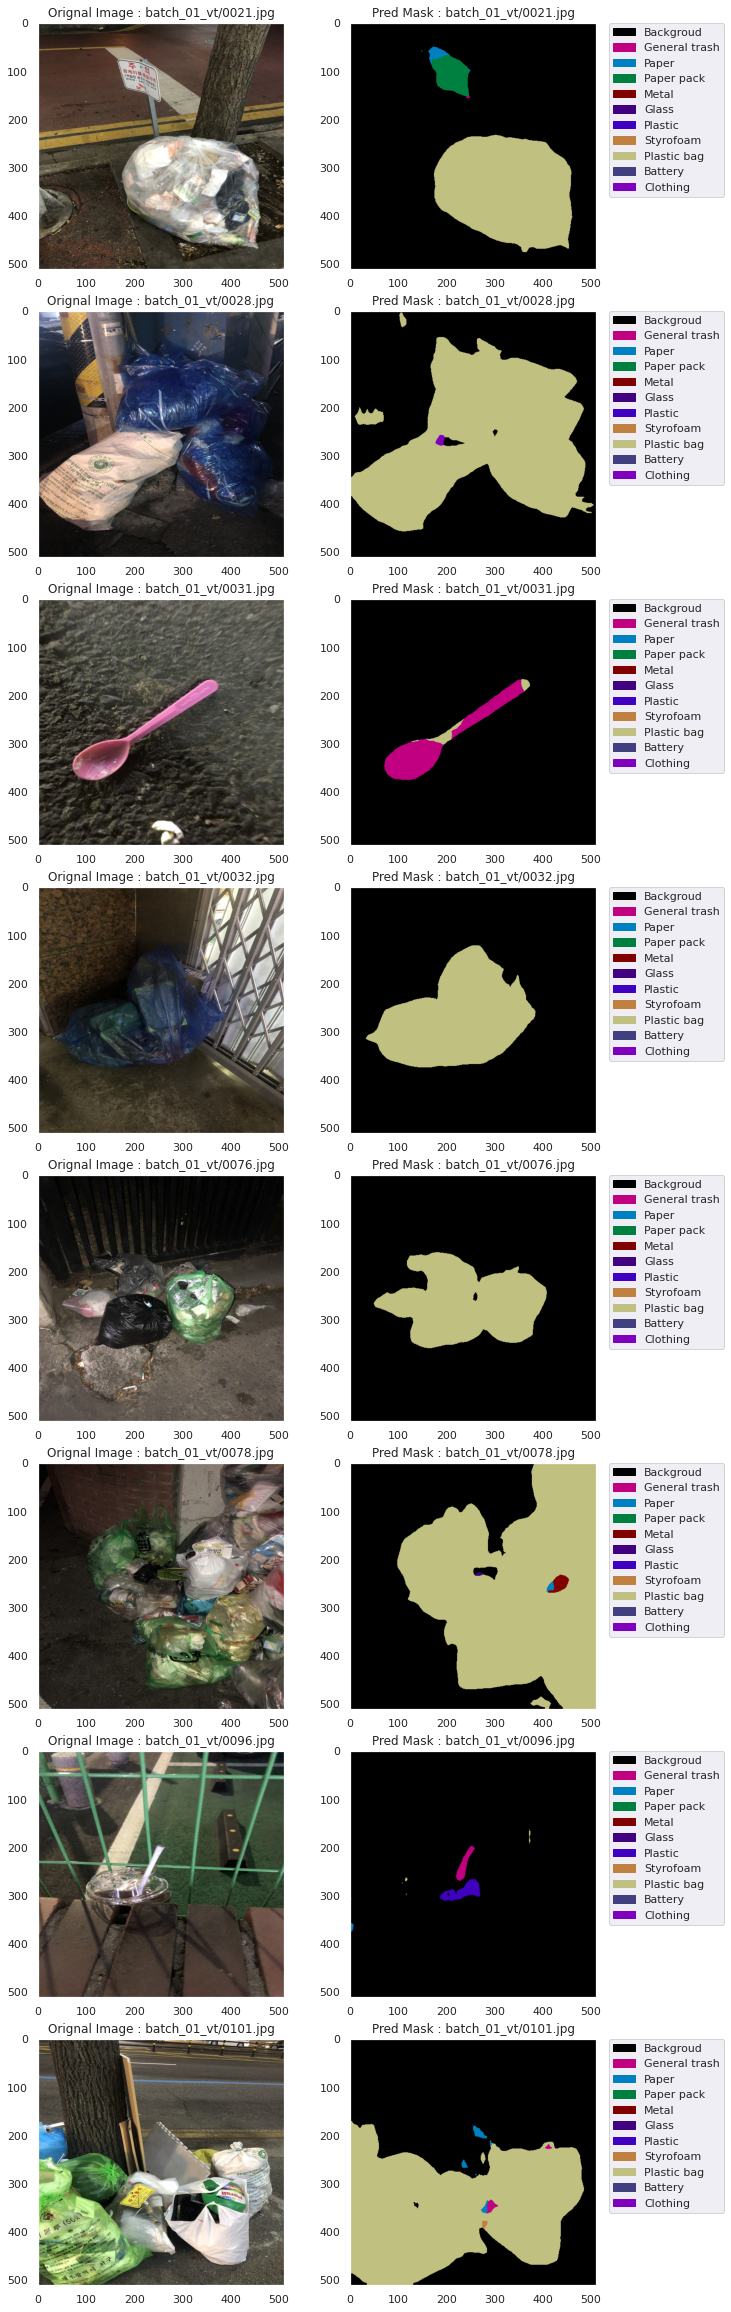

In [ ]:
plot_examples(mode="test", batch_id=0, num_examples=8, dataloaer=test_loader)

## submission을 위한 test 함수 정의

In [ ]:
def test(model, data_loader, device):
    size = 256
    transform = A.Compose([A.Resize(size, size)])
    print('Start prediction.')
    
    model.eval()
    
    file_name_list = []
    preds_array = np.empty((0, size*size), dtype=np.long)
    
    with torch.no_grad():
        for step, (imgs, image_infos) in enumerate(tqdm(test_loader)):
            
            # inference (512 x 512)
            outs = model(torch.stack(imgs).to(device))['out']
            oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()
            
            # resize (256 x 256)
            temp_mask = []
            for img, mask in zip(np.stack(imgs), oms):
                transformed = transform(image=img, mask=mask)
                mask = transformed['mask']
                temp_mask.append(mask)
                
            oms = np.array(temp_mask)
            
            oms = oms.reshape([oms.shape[0], size*size]).astype(int)
            preds_array = np.vstack((preds_array, oms))
            
            file_name_list.append([i['file_name'] for i in image_infos])
    print("End prediction.")
    file_names = [y for x in file_name_list for y in x]
    
    return file_names, preds_array

## submission.csv 생성

In [ ]:
# sample_submisson.csv 열기
submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)

# test set에 대한 prediction
file_names, preds = test(model, test_loader, device)

# PredictionString 대입
for file_name, string in zip(file_names, preds):
    submission = submission.append({"image_id" : file_name, "PredictionString" : ' '.join(str(e) for e in string.tolist())}, 
                                   ignore_index=True)

# submission.csv로 저장
submission.to_csv("./submission/fcn_resnet50_best_model(pretrained).csv", index=False)

  0%|          | 0/52 [00:00<?, ?it/s]

Start prediction.


100%|██████████| 52/52 [05:51<00:00,  5.30s/it]


End prediction.
